### RED PREDICCIÓN CONSUMO

In [3]:
# Cargamos el dataset
import pandas as pd
df = pd.read_csv("PCB.csv")

In [4]:
# Eliminamos las final con hora 24 (rango de horas [0-23]), 
# creamos la columna datetime y arreglamos el PCB
df = df.loc[df['Hour'] != 24]
df['datetime'] = pd.to_datetime(df['Day'] + ' ' + df['Hour'].astype(str).str.zfill(2), format='mixed', dayfirst=True)
df = df.drop(['Day', 'Hour'], axis=1)
df['PCB'] = df['PCB'].str.replace(',', '.').astype(float)

In [5]:
# Seleccionamos las columnas de interés
df['day_of_week'] = df['datetime'].dt.day_name()
df['Hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month_name()
df = df[['PCB', 'day_of_week', 'Hour', 'month', 'datetime']]
df.head(5)

,PCB,day_of_week,Hour,month,datetime
0,137.15,Tuesday,0,August,2021-08-03 00:00:00
1,135.93,Tuesday,1,August,2021-08-03 01:00:00
2,133.54,Tuesday,2,August,2021-08-03 02:00:00
3,132.84,Tuesday,3,August,2021-08-03 03:00:00
4,133.92,Tuesday,4,August,2021-08-03 04:00:00


In [6]:
from sklearn.preprocessing import OrdinalEncoder
import datetime

# Definimos un econder para tranformar las variables categóricas 
# (dia de la semana y mes)
enc_ord = OrdinalEncoder()

# Indicamos la fecha de separación para los conjuntos de train/val y test
# y eliminamos la columna datetime
separacion = datetime.datetime(2023, 4, 30, 23, 59)
df_train_val = df.loc[df['datetime'] < separacion]
df_test = df.loc[df['datetime'] > separacion]
df_train_val = df_train_val.drop(['datetime'], axis=1)
df_test = df_test.drop(['datetime'], axis=1)
 
# Separamos en train y validation
n = len(df_train_val)
df_train = df_train_val[:round(n * 0.7)]
df_val = df_train_val[round(n * 0.7):]
 
# Comprobamos que la suma de ambas particiones es igual al tamaño
assert len(df_test) + len(df_train) + len(df_val) == len(df)

# Normalizamos por media y desviación típica el PCB
mu = df_train['PCB'].mean()
std = df_train['PCB'].std()

df_train[['day_of_week', 'month']] = enc_ord.fit_transform(df_train[['day_of_week', 'month']])
df_train['PCB'] = (df_train['PCB'] - mu)/std

df_val[['day_of_week', 'month']] = enc_ord.transform(df_val[['day_of_week', 'month']])
df_val['PCB'] = (df_val['PCB'] - mu)/std

df_test[['day_of_week', 'month']] = enc_ord.transform(df_test[['day_of_week', 'month']])
df_test['PCB'] = (df_test['PCB'] - mu)/std

C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6668\3108130351.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['day_of_week', 'month']] = enc_ord.fit_transform(df_train[['day_of_week', 'month']])
C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6668\3108130351.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['PCB'] = (df_train['PCB'] - mu)/std
C:\Users\carloshermida\AppData\Local\Temp\ipykernel_6668\3108130351.py:31: SettingWithCopyWarning: 
A value is trying to be set on

In [7]:
# Se define la función de enventanado para que x sean 7x24 muestras y la salida y sean 1x24 datos
# De esta forma se consigue predecir el precio un dia a partir de los 7 anteriores

import numpy as np

def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)-input_width - offset - label_width):
        _x = data[i:i+input_width]
        _y = labels[i+input_width + offset : i + input_width + offset + label_width]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]

    return x, y 

In [8]:
input_width = 7 * 24 
label_width = 1 * 24
offset = 0
target_labels = 'PCB' 

# Para cada conjunto, se calculan las ventanas.
x_train, y_train = sliding_window(df_train, df_train[target_labels], input_width, label_width=label_width, offset=offset)
x_val, y_val = sliding_window(df_val, df_val[target_labels], input_width, label_width=label_width, offset=offset)
x_test, y_test = sliding_window(df_test, df_test[target_labels], input_width, label_width=label_width, offset=offset)

In [9]:
# Definimos la estructura del modelo
import tensorflow as tf
gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(units=25, return_sequences=True),  
    tf.keras.layers.GRU(units=25, return_sequences=False), 
    tf.keras.layers.Dense(units=24), 
])

In [10]:
# Definimos los parámetros del modelo

MAX_EPOCHS = 10
batch_size = 32

def entrenar_modelo(model, train_data, train_label, val_data, val_label, epochs, batch_size, patience=5, verbose = 0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_data, train_label, epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_label),
                        callbacks=[early_stopping], verbose=verbose)
    return history

In [20]:
# Entrenamos el modelo
history = entrenar_modelo(gru_model, x_train, y_train, x_val, y_val, MAX_EPOCHS, batch_size, verbose=1)

Epoch 1/10
328/328 [==============================] - 37s 98ms/step - loss: 0.5507 - mean_absolute_error: 0.5512 - val_loss: 0.4442 - val_mean_absolute_error: 0.5378
Epoch 2/10
328/328 [==============================] - 31s 93ms/step - loss: 0.3788 - mean_absolute_error: 0.4635 - val_loss: 0.3708 - val_mean_absolute_error: 0.4865
Epoch 3/10
328/328 [==============================] - 31s 93ms/step - loss: 0.3122 - mean_absolute_error: 0.4147 - val_loss: 0.3356 - val_mean_absolute_error: 0.4593
Epoch 4/10
328/328 [==============================] - 30s 91ms/step - loss: 0.2661 - mean_absolute_error: 0.3799 - val_loss: 0.2970 - val_mean_absolute_error: 0.4274
Epoch 5/10
328/328 [==============================] - 29s 90ms/step - loss: 0.2355 - mean_absolute_error: 0.3586 - val_loss: 0.3539 - val_mean_absolute_error: 0.4725
Epoch 6/10
328/328 [==============================] - 30s 92ms/step - loss: 0.2150 - mean_absolute_error: 0.3436 - val_loss: 0.2593 - val_mean_absolute_error: 0.3996
Epoc

In [22]:
# GUARDAR MODELO ENTRENADO
gru_model.save('gru_model_precio.h5')

c:\Users\carloshermida\.venvs\hackudc24\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# CARGAR MODELO ENTRENADO
gru_model = tf.keras.models.load_model('gru_model_precio.h5')

1/1 [==============================] - 1s 805ms/step


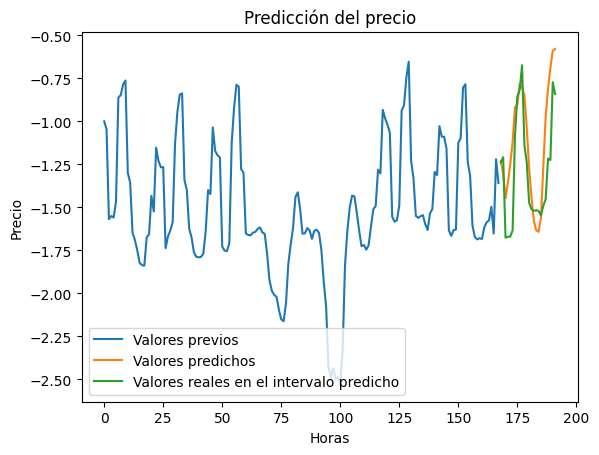

In [12]:
import matplotlib.pyplot as plt

# Elegimos un ejemplo para mostrar la predición gráficamente
# (le pasamos 7x24 (168) valores para predecir los 24 siguientes)
example = 900

valores_reales = x_test[example,:,0]
valores_predichos = gru_model.predict(x_test[example,:,:].reshape(1, 168, 4)).flatten()
valores_reales_test = y_test[example, :, 0]

indices_tiempo = np.arange(len(valores_reales) + len(valores_predichos))
plt.plot(indices_tiempo[:len(valores_reales)], valores_reales, label='Valores previos',)
plt.plot(indices_tiempo[len(valores_reales):], valores_predichos, label='Valores predichos')
plt.plot(indices_tiempo[len(valores_reales):], valores_reales_test, label='Valores reales en el intervalo predicho')

plt.xlabel('Horas')
plt.ylabel('Precio')
plt.legend()
plt.title('Predicción del precio')

plt.show()

In [27]:
# Evaluamos el modelo con test
gru_model.evaluate(x_test, y_test)

69/69 [==============================] - 2s 24ms/step - loss: 0.1941 - mean_absolute_error: 0.3460


[0.1941419243812561, 0.3459653854370117]

#### INTRODUCIR NUEVOS DATOS

In [28]:
# INTRODUCIR NUEVOS DATOS (EL USUARIO NOS PASA 168 DATOS)
# Por simplicidad suponemos se pasan los 168 últimos datos de la predicción
df = pd.read_csv("PCB.csv")
df_usuario = df[len(df)-(7*24):]
df_usuario

,Day,Hour,PCB
17496,02/08/2023,0,"124,72"
17497,02/08/2023,1,"126,77"
17498,02/08/2023,2,"126,89"
17499,02/08/2023,3,"126,81"
17500,02/08/2023,4,"124,95"
...,...,...,...
17659,08/08/2023,19,"206,23"
17660,08/08/2023,20,"222,41"
17661,08/08/2023,21,"235,60"
17662,08/08/2023,22,"188,37"


1/1 [==============================] - 0s 43ms/step


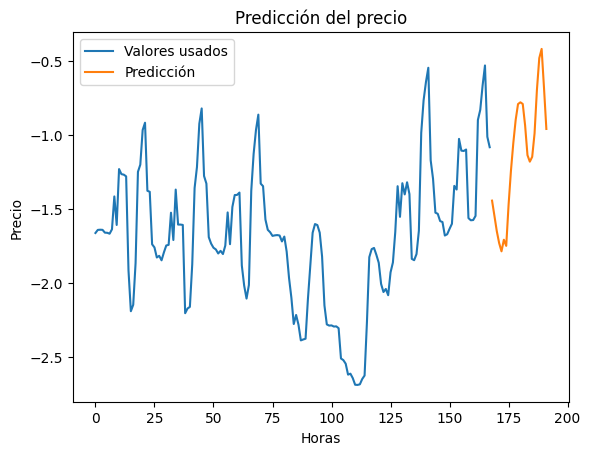

[-1.4444351  -1.5468618  -1.6502885  -1.7311752  -1.7869861  -1.7085866
 -1.7501222  -1.4722661  -1.2425728  -1.0554774  -0.89917886 -0.7918875
 -0.7800437  -0.7911454  -0.9364601  -1.1371194  -1.1811228  -1.1485287
 -0.990349   -0.696623   -0.48133337 -0.41930005 -0.68192095 -0.96007514]


In [29]:
#### EJECUTAR PARA PREDECIR

# PREPROCESADO
df_usuario = df_usuario.loc[df_usuario['Hour'] != 24]
df_usuario['datetime'] = pd.to_datetime(df_usuario['Day'] + ' ' + df_usuario['Hour'].astype(str).str.zfill(2), format='mixed', dayfirst=True)
df_usuario = df_usuario.drop(['Day', 'Hour'], axis=1)
df_usuario['PCB'] = df_usuario['PCB'].str.replace(',', '.').astype(float)
df_usuario['day_of_week'] = df_usuario['datetime'].dt.day_name()
df_usuario['Hour'] = df_usuario['datetime'].dt.hour
df_usuario['month'] = df_usuario['datetime'].dt.month_name()
df_usuario = df_usuario[['PCB', 'day_of_week', 'Hour', 'month']]

# NORMALIZACIÓN
df_usuario[['day_of_week', 'month']] = enc_ord.transform(df_usuario[['day_of_week', 'month']])
df_usuario['PCB'] = (df_usuario['PCB'] - mu)/std

# PREDICCIÓN
prediccion = gru_model.predict(df_usuario.to_numpy().reshape(1, 168, 4)).flatten()
valores_usados = df_usuario["PCB"]
indices_tiempo = np.arange(len(valores_usados) + len(prediccion))
plt.plot(indices_tiempo[:len(valores_usados)], valores_usados, label='Valores usados',)
plt.plot(indices_tiempo[len(valores_usados):], prediccion, label='Predicción')
plt.xlabel('Horas')
plt.ylabel('Precio')
plt.legend()
plt.title('Predicción del precio')
plt.show()
print(prediccion)